In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import seaborn as sns
import os

Using plaidml.keras.backend backend.


In [2]:
# Define dataset root path
dataset_root = r'R:\combined-real-and-fake-faces\combined-real-vs-fake\archive\real_vs_fake\real-vs-fake\\'  # Change to your dataset root path
train_dir = os.path.join(dataset_root, 'train')
test_dir = os.path.join(dataset_root, 'test')
val_dir = os.path.join(dataset_root, 'valid')

In [3]:
# Custom data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode='binary')
test_generator = data_gen.flow_from_directory(test_dir, target_size=(64, 64), batch_size=32, class_mode='binary', shuffle=False)
val_generator = data_gen.flow_from_directory(val_dir, target_size=(64, 64), batch_size=32, class_mode='binary')


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
# Custom CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Model summary
model.summary()

INFO:plaidml:Opening device "opencl_nvidia_nvidia_geforce_rtx_4060_laptop_gpu.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [5]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history= model.fit_generator(train_generator, epochs=25, validation_data=val_generator)


Epoch 1/25
3189/3189 [==============================] - 276s 87ms/step - loss: 0.7313 - acc: 0.5333 - val_loss: 0.6820 - val_acc: 0.5654
Epoch 2/25
3189/3189 [==============================] - 213s 67ms/step - loss: 0.6861 - acc: 0.5540 - val_loss: 0.6878 - val_acc: 0.5474
Epoch 3/25
3189/3189 [==============================] - 177s 55ms/step - loss: 0.6821 - acc: 0.5628 - val_loss: 0.6791 - val_acc: 0.5805
Epoch 4/25
3189/3189 [==============================] - 180s 56ms/step - loss: 0.6806 - acc: 0.5646 - val_loss: 0.6763 - val_acc: 0.5784
Epoch 5/25
3189/3189 [==============================] - 213s 67ms/step - loss: 0.6779 - acc: 0.5714 - val_loss: 0.6730 - val_acc: 0.5821
Epoch 6/25
3189/3189 [==============================] - 219s 69ms/step - loss: 0.6763 - acc: 0.5764 - val_loss: 0.6715 - val_acc: 0.5908
Epoch 7/25
3189/3189 [==============================] - 182s 57ms/step - loss: 0.6744 - acc: 0.5803 - val_loss: 0.6808 - val_acc: 0.5783
Epoch 8/25
3189/3189 [===================

In [6]:
# Save the model
model.save('custom_cnn_augmented.h5')
print("Model saved as custom_cnn_augmented.h5")


Model saved as custom_cnn_augmented.h5


In [7]:
# Plot loss function
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot accuracy function
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [9]:

# Retrieve training history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


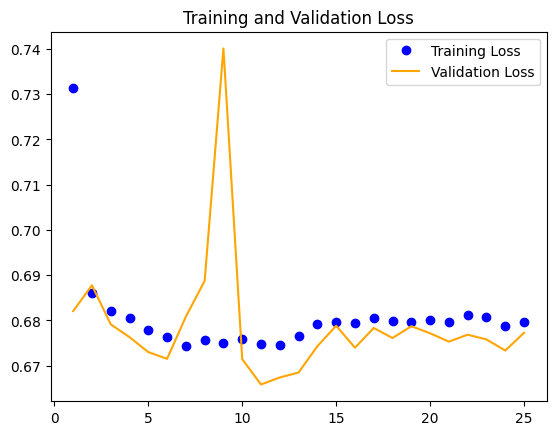

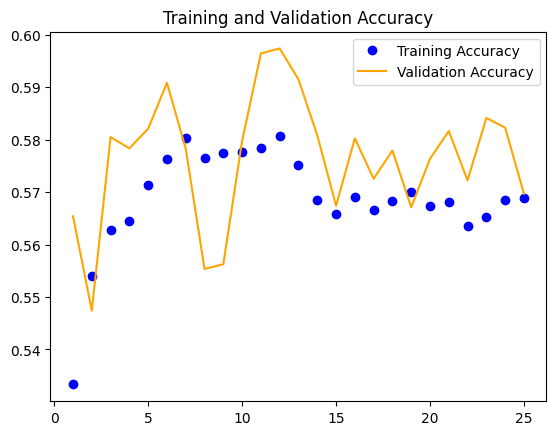

In [10]:
# Plot training history
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(acc) + 1), acc, val_acc)


In [11]:
import numpy as np

# Store predictions and true labels
y_pred_list = []
y_true_list = []

# Iterate over all batches in the test generator
for i in range(len(test_generator)):
    X_batch, y_batch = next(test_generator)  # Get batch images & labels
    y_pred_batch = model.predict(X_batch, verbose=0)  # Predict batch
    y_pred_list.extend(y_pred_batch.flatten())  # Store predictions
    y_true_list.extend(y_batch.flatten())  # Store true labels

# Convert predictions to binary labels (0 = Fake, 1 = Real)
y_pred_classes = (np.array(y_pred_list) > 0.5).astype(int)
y_true_classes = np.array(y_true_list)

# Print predictions and true labels
print("Predicted Labels:", y_pred_classes)
print("Actual Labels:", y_true_classes)


Predicted Labels: [0 0 0 ... 1 1 0]
Actual Labels: [0. 0. 0. ... 1. 1. 1.]


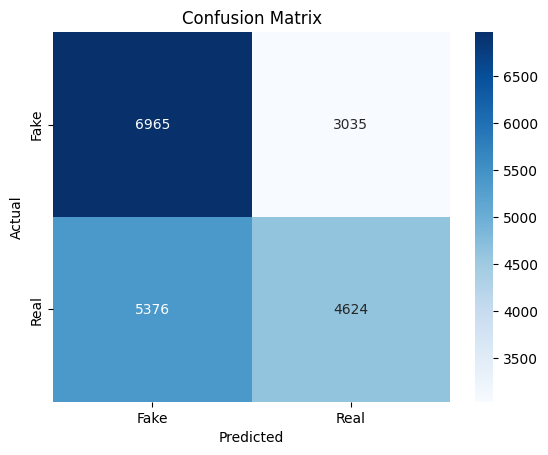

In [12]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.56      0.70      0.62     10000
        Real       0.60      0.46      0.52     10000

    accuracy                           0.58     20000
   macro avg       0.58      0.58      0.57     20000
weighted avg       0.58      0.58      0.57     20000



In [14]:
# Compute and print additional metrics
print("ROC AUC Score:", roc_auc_score(y_true_classes,y_pred_classes))
print("AP Score:", average_precision_score(y_true_classes, y_pred_classes))


ROC AUC Score: 0.57945
AP Score: 0.5479666797232015


In [15]:
import cv2
import numpy as np

def predict_image(img_path):
    img = cv2.imread(img_path)

    # ✅ Check if the image was loaded successfully
    if img is None:
        print(f"Error: Unable to load image at {img_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)[0][0]
    pred_label = 'Real' if prediction > 0.5 else 'Fake'
    print(f'The image at {img_path} is predicted as: {pred_label} (Confidence: {prediction:.2f})')
    
    return pred_label

# Example usage
img_path = r"R:\real_sanki.jpg" # ✅ Make sure the path is correct
predict_image(img_path)


The image at R:\real_sanki.jpg is predicted as: Fake (Confidence: 0.37)


'Fake'